In [1]:
%run c:/Users/elapo/OneDrive/Dokumenty/prf/dp/code/tools.py


In [2]:
import tools
print(dir(tools))


['Moran', 'Polygon', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'build_g', 'coo_array', 'csr_matrix', 'diags', 'generate_square_lattice', 'gpd', 'graph', 'identity', 'np', 'plt', 'remove_random_edges', 'sns', 'spmatrix', 'spsolve', 'triu']


In [1]:
from scipy.sparse import identity, csr_matrix
from scipy.sparse.linalg import spsolve
import geopandas as gpd
#import pandas as pd
import numpy as np
#from libpysal.weights import Queen, Rook
import matplotlib.pyplot as plt
from esda.moran import Moran
from shapely.geometry import Polygon
#import copy
import seaborn as sns
from libpysal import graph,weights
#from splot.libpysal import plot_spatial_weights
from scipy.sparse import spmatrix, triu, diags, coo_array
from tools import generate_square_lattice,build_g,remove_random_edges

#from spreg import ML_Error

Set lattice size.

In [2]:
l = 10

In [4]:
def plot_lattice(gdf):    
    # Plot grid geotable
    ax = gdf.plot(facecolor="w", edgecolor="k")

    # Loop over each cell and add the text
    for x, y, t in zip(
        [p.centroid.x - 0.25 for p in gdf["geometry"]],
        [p.centroid.y - 0.25 for p in gdf["geometry"]],
        [i for i in gdf["id"]],
    ):
        plt.text(
            x,
            y,
            t,
            verticalalignment="center",
            horizontalalignment="center",
        )

    # Remove axes
    ax.set_axis_off()
    plt.show()
    


Parameters for datta simulation, different spatial autocorrelations.

In [5]:
rhos = np.arange(-0.9, 1.0, 0.1)
n_runs = 10

In [3]:
def simulate_data(gdf, W):    
    # 3. Simulate spatially autocorrelated values
    
    n = len(gdf)
    I = identity(n)

    for rho in rhos:
        for run in range(n_runs):
            epsilon = np.random.normal(0, 1, n)
            y = spsolve(I - rho * W, epsilon)
            col_name = f"rho_{rho:.1f}_run_{run}"
            gdf[col_name] = y
        #print(rho)

In [8]:
def plot_data(gdf,w):
    cols = 5
    rows = (len(rhos) // cols) + (1 if len(rhos) % cols else 0)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
    axes = axes.flatten()

    for i, rho in enumerate(rhos):
        col = f"rho_{rho:.1f}"
        ax = axes[i]

        # Plot the simulated SAR attribute
        gdf.plot(column=col, ax=ax, cmap='viridis',
                linewidth=0.05, edgecolor='gray')

        # Compute Moran's I
        

        # Title with rho
        ax.set_title(f"$\\rho$ = {rho:.1f}")
        
        mi = Moran(gdf[col], w)
        # Annotate Moran's I and p-value inside plot
        ax.text(0.03, 0.03,
                f"I = {mi.I:.3f}\np = {mi.p_sim:.3f}",
                transform=ax.transAxes,
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))

        ax.axis('off')

    # Remove empty axes (if any)
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()

Create lattice gdf, bulid correct graph and simulate data.

In [6]:

gdf = generate_square_lattice(l)
g_correct = build_g(gdf)
simulate_data(gdf,g_correct.sparse)

c:\Users\elapo\OneDrive\Dokumenty\prf\dp\code\.pixi\envs\default\Lib\site-packages\geopandas\geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\Users\elapo\OneDrive\Dokumenty\prf\dp\code\.pixi\envs\default\Lib\site-packages\geopandas\geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\Users\elapo\OneDrive\Dokumenty\prf\dp\code\.pixi\envs\default\Lib\site-packages\geopandas\geodataframe.py:1968: PerformanceWarning: DataFrame is 

Set parameters for graph corruption.

In [7]:
perc_missing = np.linspace(0, 0.95, 20)     # 0–50 % edges removed
n_corrupt = 10                            # number of corruption replicates
w_correct=g_correct.to_W()
w_correct_sparse = w_correct.sparse

Create dictionary with correct Morans Is for eacht simulated attribute.

In [8]:
I_true_dict = {}

for i, rho in enumerate(rhos):
    col_prefix = f"rho_{rho:.1f}"
    for y_run in range(n_runs):
        y = gdf[f"{col_prefix}_run_{y_run}"].values
        I_true_dict[(rho, y_run)] = Moran(y, w_correct).I

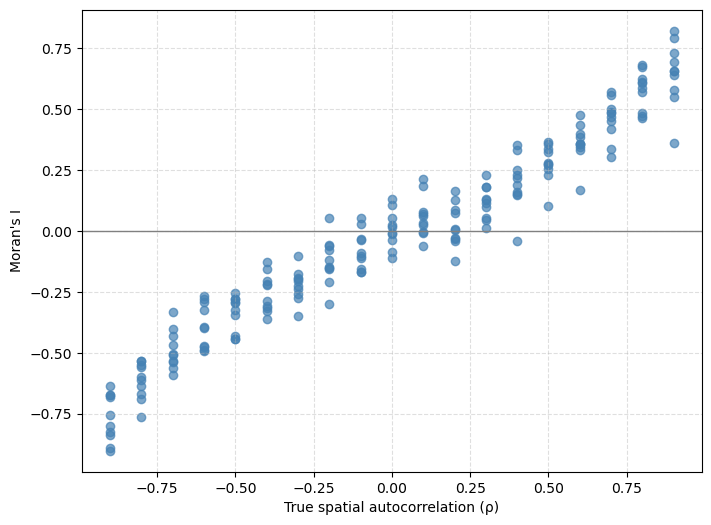

In [11]:
plt.figure(figsize=(8, 6))

# Loop through each unique rho in your dictionary
for rho in sorted(set(r for (r, _) in I_true_dict.keys())):
    # Get all Moran’s I values for this rho
    I_vals = [I_true_dict[(rho, run)] for (r, run) in I_true_dict if r == rho]

    # Plot all points for this rho at the same x position
    plt.scatter([rho] * len(I_vals), I_vals, color='steelblue', alpha=0.7)

# Style and labels
plt.axhline(0, color='gray', lw=1)
plt.xlabel("True spatial autocorrelation (ρ)")
plt.ylabel("Moran's I")
plt.grid(True, linestyle="--", alpha=0.4)

In [12]:
results = np.zeros((n_corrupt, len(perc_missing), len(rhos), n_runs))

In [13]:
for c_run in range(n_corrupt):
    for j, p in enumerate(perc_missing):
        # --- Step 1: corrupt the graph ---
        w_new = remove_random_edges(w_correct_sparse, p)
        w_cor = graph.Graph.from_sparse(w_new, ids=g_correct.unique_ids).to_W()

        # --- Step 2: loop over rho columns ---
        for i, rho in enumerate(rhos):
            col_prefix = f"rho_{rho:.1f}"
            

            for n_run in range(n_runs):
                y = gdf[f"{col_prefix}_run_{n_run}"].values
                I_true = I_true_dict[(rho, n_run)]

                I_cor = Moran(y, w_cor).I
                # save absolute difference in preallocated array
                results[c_run,j,i,n_run] = abs(I_cor-I_true)
                #print(abs(I_cor-I_true))

delta_I_mean = results.mean(axis=(0, 3)).T

KeyboardInterrupt: 

In [15]:
results = np.load("results.npy")
delta_I_mean = results.mean(axis=(0, 3)).T

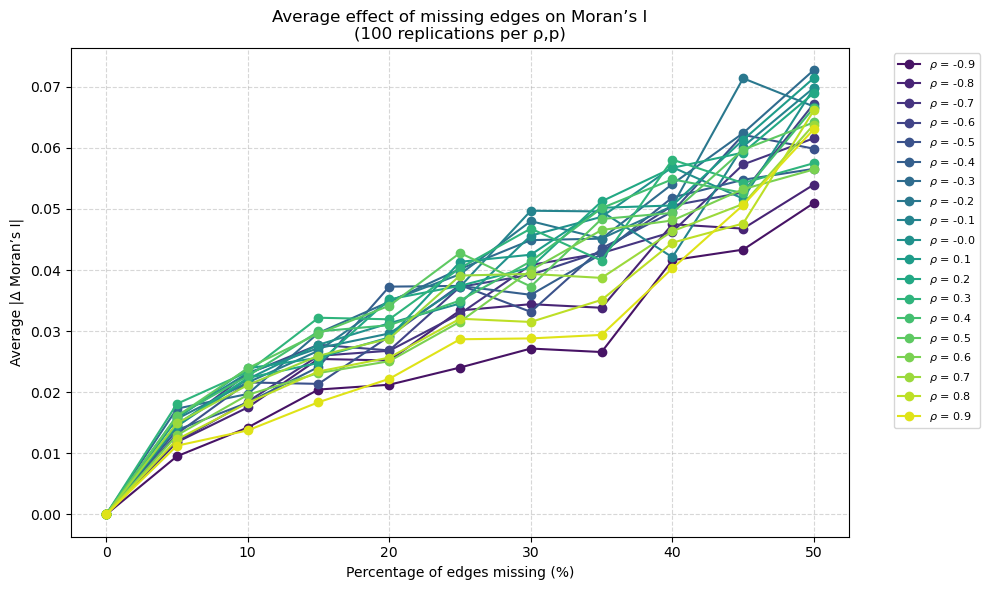

In [16]:

# Plot
plt.figure(figsize=(10,6))
palette = sns.color_palette("viridis", len(rhos))


for i, rho in enumerate(rhos):
    plt.plot(perc_missing*100,
             delta_I_mean[i],
             color=palette[i],
             marker='o',
             label=f"$\\rho$ = {rho:.1f}")

plt.xlabel("Percentage of edges missing (%)")
plt.ylabel("Average |Δ Moran’s I|")
plt.title(f"Average effect of missing edges on Moran’s I\n({n_runs*n_corrupt} replications per ρ,p)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=8)
plt.tight_layout()


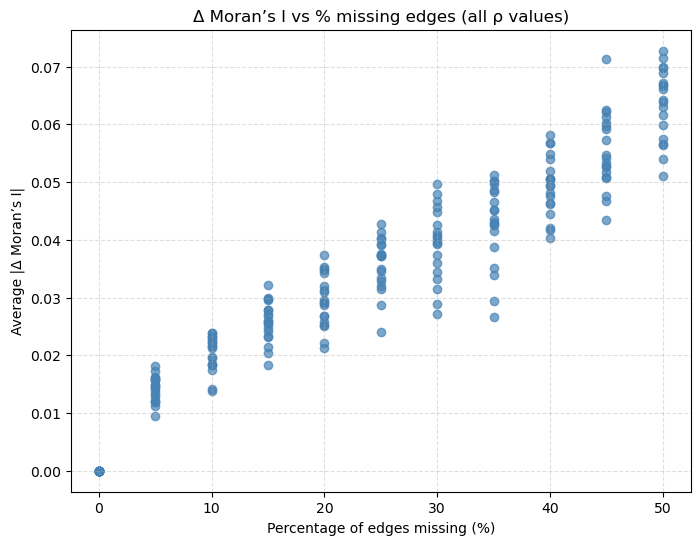

In [18]:
plt.figure(figsize=(8, 6))

for i, p in enumerate(perc_missing):
    # y-values for all rhos at this percentage
    y_vals = delta_I_mean[:, i]  # one per rho
    plt.scatter([p * 100] * len(y_vals), y_vals, c='steelblue', alpha=0.7)

plt.xlabel("Percentage of edges missing (%)")
plt.ylabel("Average |Δ Moran’s I|")
plt.title("Δ Moran’s I vs % missing edges (all ρ values)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


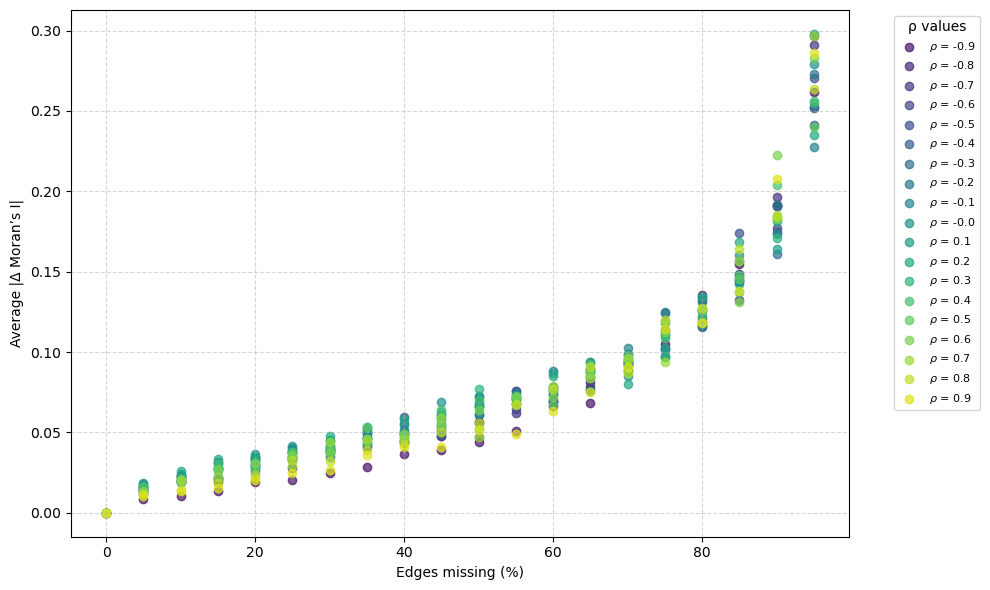

In [17]:
plt.figure(figsize=(10, 6))
palette = sns.color_palette("viridis", len(rhos))

for i, rho in enumerate(rhos):
    # y-values for this rho across all % missing
    y_vals = delta_I_mean[i, :]  # shape = (len(perc_missing),)
    
    # plot each percentage as a scatter point
    plt.scatter(perc_missing * 100,
                y_vals,
                color=palette[i],
                label=f"$\\rho$ = {rho:.1f}",
                alpha=0.7)

plt.xlabel("Edges missing (%)")
plt.ylabel("Average |Δ Moran’s I|")
#plt.title(f"Effect of missing edges on Moran’s I\n({n_runs*n_corrupt} replications per ρ,p)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8, title="ρ values")
plt.tight_layout()

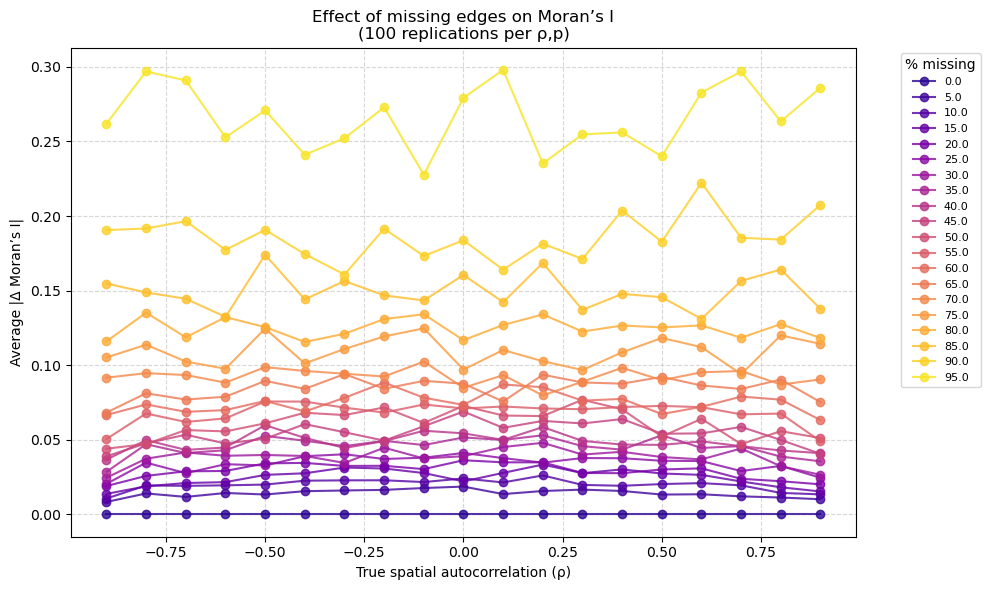

In [32]:
plt.figure(figsize=(10, 6))
palette = sns.color_palette("plasma", n_colors=len(perc_missing))


for j, p in enumerate(perc_missing):
    y_vals = delta_I_mean[:, j]  # len(rhos)
    
    plt.plot(rhos,
             y_vals,
             color=palette[j],
             marker='o',
             label=f"{round(p*100,0)}",
             alpha=0.8)

plt.xlabel("True spatial autocorrelation (ρ)")
plt.ylabel("Average |Δ Moran’s I|")
plt.title(f"Effect of missing edges on Moran’s I\n({n_runs*n_corrupt} replications per ρ,p)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8, title="% missing")
plt.tight_layout()

In [38]:
np.save("results.npy",results)